# Along isopycnal spice gradients

Here we consider the properties of spice gradients along isopycnals. We do this using the 2 point differences and their distributions. 

This is similar (generalization) to the spice gradients that Klymak et al 2015 considered. 

In [56]:
import numpy as np
import xarray as xr

import glidertools as gt
from cmocean import cm as cmo

import gsw

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import ticker

plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 8

In [2]:
ds_659_rho = xr.open_dataset('../data/sg_659_iso_grid.nc')
ds_660_rho = xr.open_dataset('../data/sg_660_iso_grid.nc')

# compute spice 
# Pick constant alpha and beta for convenience (can always update later)
alpha_659 = gsw.alpha(ds_659_rho.SA, ds_659_rho.CT, ds_659_rho.ctd_pressure)
alpha_660 = gsw.alpha(ds_660_rho.SA, ds_660_rho.CT, ds_660_rho.ctd_pressure)
#alpha = 8.3012133e-05
#beta  = 0.00077351

#
dCT_659 = ds_659_rho.CT  - ds_659_rho.CT.mean('dives')
dSA_659 = ds_659_rho.SA  - ds_659_rho.SA.mean('dives')

ds_659_rho['Spice'] = (2*alpha_659*dCT_659).rename('Spice')

# remove a mean per isopycnal
dCT_660 = ds_660_rho.CT  - ds_660_rho.CT.mean('dives')
dSA_660 = ds_660_rho.SA - ds_660_rho.SA.mean('dives')

ds_660_rho['Spice'] = (2*alpha_660*dCT_660).rename('Spice')

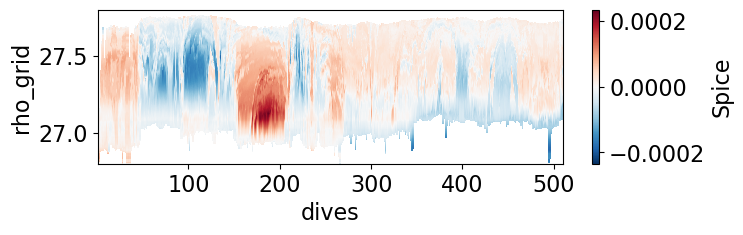

In [16]:
plt.figure(figsize=(7.5,2))

ds_660_rho.Spice.plot()

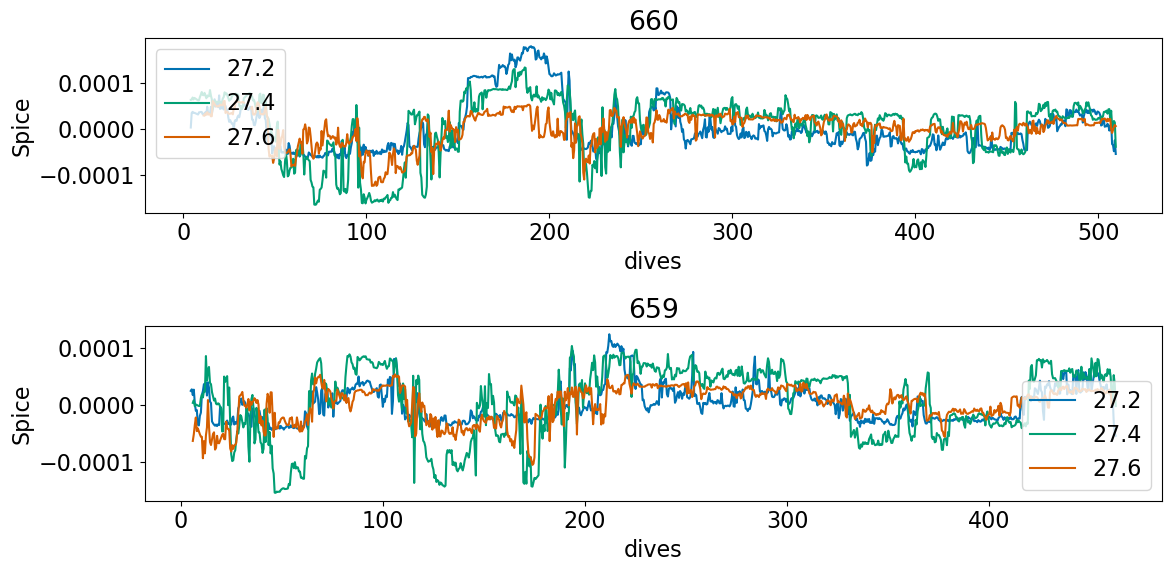

In [3]:
plt.figure(figsize=(12,6))

plt.subplot(211)
ds_660_rho.Spice.sel(rho_grid=27.2, method='nearest').plot(label='27.2')
ds_660_rho.Spice.sel(rho_grid=27.4, method='nearest').plot(label='27.4')
ds_660_rho.Spice.sel(rho_grid=27.6, method='nearest').plot(label='27.6')
plt.legend()
plt.title('660')

plt.subplot(212)
ds_659_rho.Spice.sel(rho_grid=27.2, method='nearest').plot(label='27.2')
ds_659_rho.Spice.sel(rho_grid=27.4, method='nearest').plot(label='27.4')
ds_659_rho.Spice.sel(rho_grid=27.6, method='nearest').plot(label='27.6')
plt.legend()
plt.title('659')

plt.tight_layout()

### Analysis at a couple of single depths

In [4]:
from scipy.spatial.distance import pdist
import extra_funcs as ef

#### Along isopycnal spice gradient PDFs

In [71]:
spatial_bins=np.logspace(2,6,17)

def select_data(rho_sel):
    # function to find the dX and dSpice from the different data sets and merging them
    
    # # 660
    # ds_sel   = ds_660_rho.sel(rho_grid=rho_sel, method='nearest')

    # lon_sel  = ds_sel.longitude.values.reshape((-1,1))
    # lat_sel  = ds_sel.latitude.values.reshape((-1,1))
    # time_sel = ds_sel.days.values.reshape((-1,1))

    # Spice_sel = ds_sel.Spice.values.reshape((-1,1))

    # Xvec = np.concatenate([lon_sel, lat_sel], axis=1) # mXn, where m is number of obs and n is dimension

    # dX_660     = pdist(Xvec, ef.great_circle_distance_2in)*110e3 # convert to m
    # dTime_660  = pdist(time_sel, 'cityblock')
    # dSpice_660 = pdist(Spice_sel, 'cityblock') # we just want to know the abs diff

    # # 659
    # ds_sel   = ds_659_rho.sel(rho_grid=rho_sel, method='nearest')

    # lon_sel  = ds_sel.longitude.values.reshape((-1,1))
    # lat_sel  = ds_sel.latitude.values.reshape((-1,1))
    # time_sel = ds_sel.days.values.reshape((-1,1))

    # Spice_sel = ds_sel.Spice.values.reshape((-1,1))

    # Xvec = np.concatenate([lon_sel, lat_sel], axis=1) # mXn, where m is number of obs and n is dimension

    # dX_659 = pdist(Xvec, ef.great_circle_distance_2in)*110e3 # convert to m
    # dTime_659 = pdist(time_sel, 'cityblock')
    # dSpice_659 = pdist(Spice_sel, 'cityblock') # we just want to know the abs diff

    # # combine data
    # dX = np.concatenate([dX_659, dX_660])
    # dTime = np.concatenate([dTime_659, dTime_660])
    # dSpice = np.concatenate([dSpice_659, dSpice_660])

    # all 
    ds_sel_660   = ds_660_rho.sel(rho_grid=rho_sel, method='nearest')
    ds_sel_659   = ds_660_rho.sel(rho_grid=rho_sel, method='nearest')
    

    lon_sel  = np.concatenate(( ds_sel_660.longitude.values.reshape((-1,1)), 
                               ds_sel_659.longitude.values.reshape((-1,1)) ))
    lat_sel  = np.concatenate(( ds_sel_660.latitude.values.reshape((-1,1)), 
                               ds_sel_659.latitude.values.reshape((-1,1)) ))
    time_sel = np.concatenate(( ds_sel_660.days.values.reshape((-1,1)), 
                               ds_sel_659.days.values.reshape((-1,1)) ))

    Spice_sel = np.concatenate(( ds_sel_660.Spice.values.reshape((-1,1)), 
                               ds_sel_659.Spice.values.reshape((-1,1)) ))

    Xvec = np.concatenate([lon_sel, lat_sel], axis=1) # mXn, where m is number of obs and n is dimension

    dX_all     = pdist(Xvec, ef.great_circle_distance_2in)*110e3 # convert to m
    dTime_all  = pdist(time_sel, 'cityblock')
    dSpice_all = pdist(Spice_sel, 'cityblock') # we just want to know the abs diff
    
    # condition
    cond = (dTime_all <= 2e-3*dX_all**(2/3)) 
    
    return dX_all[cond], dSpice_all[cond]

In [109]:
rho_sel = 27.6 # 27.2, 27.4, 27.6

dX_sel, dSpice_sel = select_data(rho_sel)

# estimate pdfs
Hspice, xedges, yedges = np.histogram2d(dX_sel, dSpice_sel/dX_sel,
                                      bins=(spatial_bins, np.logspace(-14, -6, 37)))
xmid = 0.5*(xedges[0:-1] + xedges[1:])
ymid = 0.5*(yedges[0:-1] + yedges[1:])

#dX_edges = xedges[1:] - xedges[0:-1]
#dY_edges = yedges[1:] - yedges[0:-1]

Hspice_Xdnorm = Hspice/ Hspice.sum(axis=1).reshape((-1,1))

mean_dist = np.zeros((len(xmid,))) # mean of the distribution

for i in range(len(xmid)):
    mean_dist[i] = np.sum(Hspice_Xdnorm[i, :]*ymid)

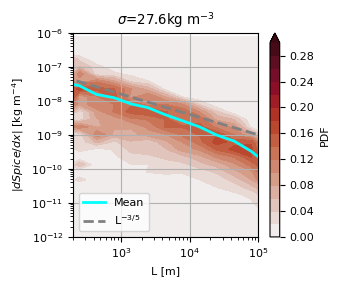

In [110]:
plt.figure(figsize=(3.4,2.9))
#plt.pcolor(xedges, yedges, Hspice_Xdnorm.T, norm=colors.LogNorm(vmin=1e-3, vmax=0.3),
#          cmap=cmo.amp)
plt.contourf(xmid, ymid, Hspice_Xdnorm.T, 
             vmin=0.01, vmax=0.3, levels=np.linspace(0,0.3,16),# norm=colors.LogNorm(vmin=1e-3),
          cmap=cmo.amp, extend='max')
plt.plot(xmid, mean_dist , linewidth=2., color='cyan', label='Mean')
plt.plot(xmid, 1e-6*xmid**-.6, '--',linewidth=2, color='gray', label='L$^{-3/5}$')
plt.colorbar(label='PDF', 
            orientation='vertical')
 
plt.xscale('log')
plt.yscale('log')
plt.xlabel('L [m]')
plt.ylabel(r'$|dSpice/dx|$ [kg m$^{-4}$]')

plt.legend(loc='lower left')
plt.ylim([1e-12, 1e-6])
plt.xlim([2e2, 1e5])

plt.grid()
plt.title('$\sigma$='+str(rho_sel)+'kg m$^{-3}$')
plt.tight_layout()

plt.savefig('./figures/figures_spice_gradients_panel'+str(rho_sel)+'.pdf')

### Compute the structure functions at many depths 

### Structure functions 

Here we consider the structure functions; quantities like $<d\tau ^n>$.

Power law scalings go as, at $k^{-\alpha}$ in power spectrum will appear at $r^{\alpha-1}$ in spectra.  
So a power law scaling of 2/3 corresponds to $-5/3$, while shallower than 2/3 would correspond to shallower. 

In [53]:
rho_sels = ds_660_rho.rho_grid[0:-1:15]

In [ ]:
# estimate the structure functions 
# We will do the distribution calculations at a few depths

#spatial_bins=np.logspace(2,6,17)


S2 = np.zeros((len(rho_sels),len(spatial_bins)-1))
S4 = np.zeros((len(rho_sels),len(spatial_bins)-1))


for count, rho_sel in enumerate(rho_sels):
    print(count)
    
    dX_cond, dSpice_cond = select_data(rho_sel)
    
    # compute the structure functions
    for i in range(len(spatial_bins)-1): 
        S2[count, i] = np.nanmean(dSpice_cond[ (dX_cond> spatial_bins[i]) & (dX_cond <= spatial_bins[i+1])]**2)
        S4[count, i] = np.nanmean(dSpice_cond[ (dX_cond> spatial_bins[i]) & (dX_cond <= spatial_bins[i+1])]**4)
    

0
1
2
3


Unlike the surface buoyancy gradients, there is less of a suggestion of saturation at the small scales. Suggesting that even if the is a natural limit to the smallest gradients (wave mixing or such), it is not reached at a few 100m. 

This result seems to be similar, regardless of the isopycnal we are considering (tried this by changing the density level manually). 

Things to try: 
- Second order structure functions (do they look more like k^-1 or k^-2?) 
- 4th order structure functions could also help as a summary metric

In [47]:
spatial_bins_mid = 0.5*(spatial_bins[0:-1] + spatial_bins[1:])

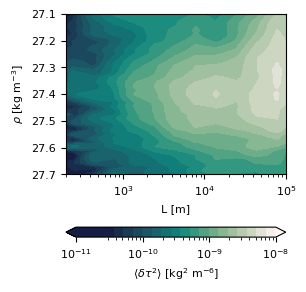

In [105]:
plt.figure(figsize=(3.1, 3))

lev_exp = np.linspace(-11,-8, 22)
levs = np.power(10, lev_exp)

cnt = plt.contourf(spatial_bins_mid, rho_sels, S2, levels=levs,
             norm = colors.LogNorm(3e-11), extend='both',
            cmap=cmo.tempo_r)

for c in cnt.collections:
    c.set_edgecolor("face")
    
plt.xscale('log')
plt.colorbar(ticks=[1e-11, 1e-10, 1e-9, 1e-8], 
             label=r'$\left< \delta \tau ^2\right> $ [kg$^2$ m$^{-6}$]',
             orientation='horizontal', pad=0.21)

plt.ylim([27.7, 27.1])
plt.xlim([2e2, 1e5])

plt.ylabel(r'$\rho$ [kg m$^{-3}$]')
plt.xlabel('L [m]')

plt.tight_layout()

plt.savefig('figures/figure_iso_spec_freq_panel4.pdf')


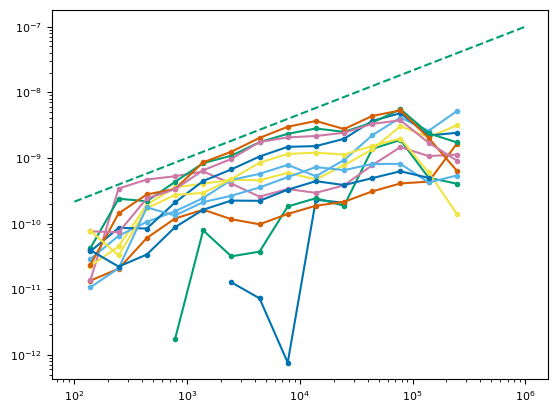

In [142]:
plt.plot(spatial_bins_mid, S2[1:-1:5,:].T, '.-');

plt.plot(spatial_bins, 1e-11*spatial_bins**(2/3), '--')
plt.xscale('log')
plt.yscale('log')

In [159]:
# Fit slope
npres = len(rho_sels)
m_mean = np.zeros((npres,))

L1 = 7e2
L2 = 10e3

x = spatial_bins_mid[(spatial_bins_mid>=L1) & (spatial_bins_mid<=L2)]

for i in range(npres):
    
    y = S2[i, (spatial_bins_mid>=L1) & (spatial_bins_mid<=L2)]
    
    if ~np.any(np.isnan(y)):
        m_mean[i],b = np.polyfit(np.log(x), np.log(y),1)
    else:
        m_mean[i] = np.nan
   

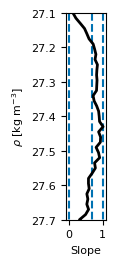

In [160]:
plt.figure(figsize=(1.2,2.7))
plt.plot(m_mean, rho_sels, color='k', linewidth=2)

plt.vlines([0,2/3,1], 27.1, 27.7, linestyles='--')

plt.gca().invert_yaxis()
plt.ylim([27.7, 27.1])

plt.xlim([-.1,1.1])

plt.xlabel('Slope')
plt.ylabel(r'$\rho$ [kg m$^{-3}$]')

plt.tight_layout()
plt.savefig('figures/figure_iso_spec_freq_panel5.pdf')


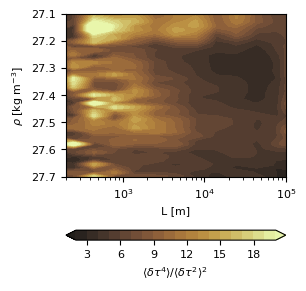

In [104]:
plt.figure(figsize=(3.1, 3))


cnt = plt.contourf(xmid, rho_sels, S4/ S2**2, levels=np.linspace(2, 20, 19), extend='both', cmap=cmo.turbid_r)
for c in cnt.collections:
    c.set_edgecolor("face")
    
plt.xscale('log')
plt.colorbar(ticks=[3, 6, 9, 12,15, 18], 
             label=r'$\left< \delta \tau ^4 \right> / \left< \delta \tau ^2\right>^2 $ ',
            orientation='horizontal', pad=0.21)


plt.ylim([27.7, 27.1])
plt.xlim([2e2, 1e5])

plt.ylabel(r'$\rho$ [kg m$^{-3}$]')
plt.xlabel('L [m]')

plt.tight_layout()
plt.savefig('figures/figure_iso_spec_freq_panel6.pdf')
#plt.gca().invert_yaxis()

The second order structure of spice follow as power law of about 2/3, which corresponds to about -5/3 slope of tracers. This is slightly at odds with the $k^{-2}$. scaling seen in wavenumber. However, note that this is still very far from $r^0$ (constant) that one might expect is the $k^{-1}$ case (which is what theory would predict). 